In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

### 1. Load data and initial inspection

In [2]:
df = pd.read_csv(r"RUS_combined_data.csv")
df.head()

,Unnamed: 0,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
0,0,35648046,TOYOTA,SEQUOIA,1/1/2020 0:03,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000
1,1,35648049,MITSUBISHI,COLT,1/1/2020 0:06,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000
2,2,35648071,HYUNDAI,ELANTRA,1/1/2020 0:20,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000
3,3,35648091,MERCEDES-BENZ,SPRINTER 311,1/1/2020 0:15,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000
4,4,35648093,MERCEDES-BENZ,E 240,1/1/2020 0:17,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000


In [3]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354392 entries, 0 to 2354391
Data columns (total 7 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   id                       int64 
 1   car_brand                object
 2   car_model                object
 3   violation_date           object
 4   crossroad_name           object
 5   violation_protocol_name  object
 6   violation_ammount        int64 
dtypes: int64(2), object(5)
memory usage: 125.7+ MB


In [4]:
df.isnull().sum()
df.shape

(2354392, 7)

In [5]:
df = df.dropna()
df.shape

(2354369, 7)

In [6]:
df.nunique()

id                         1915019
car_brand                      242
car_model                     3194
violation_date             1978515
crossroad_name                 552
violation_protocol_name         20
violation_ammount                4
dtype: int64

In [7]:
if df["id"].is_unique:
    print("id unique")
else:
    print("id is not unique, there are duplicates")
total_rows = len(df)
unique_ids = df["id"].nunique()

print("Total rows:", total_rows)
print("Unique id:", unique_ids)

id is not unique, there are duplicates
Total rows: 2354369
Unique id: 1915019


In [8]:
dup_ids = df.loc[df["id"].duplicated(), "id"]
dup_ids.head()

256337    206208
256342     91231
256350     38233
256359     63396
256379    167667
Name: id, dtype: int64

I wanna understand why these entries aren't unique.
It looks as if the same driver or the same vehicle is repeatedly committing violations

In [9]:
df[df["id"] == 38233]

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
256349,38233,HONDA,FIT,2019-03-04 01:16:21.000,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 20 км/ч,...",3000
256350,38233,HONDA,FIT,2019-03-04 01:18:20.000,А/д Бишкек - Торугарт 12.9км,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000
282567,38233,HONDA,FIT,2019-03-21 03:34:27.000,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 20 км/ч,...",3000
328861,38233,HONDA,FIT,2019-04-19 08:08:53.000,г. Бишкек ул.Ж.Жолу д.291,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000


In [10]:
print('Quantity of rows with duplicates:', df.duplicated().sum())
df.drop_duplicates(inplace=True) # Dropping duplicates
print('Shape of df', df.shape)

Quantity of rows with duplicates: 130725
Shape of df (2223644, 7)


In [11]:
df.head()

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
0,35648046,TOYOTA,SEQUOIA,1/1/2020 0:03,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000
1,35648049,MITSUBISHI,COLT,1/1/2020 0:06,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000
2,35648071,HYUNDAI,ELANTRA,1/1/2020 0:20,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000
3,35648091,MERCEDES-BENZ,SPRINTER 311,1/1/2020 0:15,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000
4,35648093,MERCEDES-BENZ,E 240,1/1/2020 0:17,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000


In [12]:
df["violation_date"].astype(str).value_counts().sample(100)

violation_date
21/02/2021 08:51:51    1
26/07/2020 09:31:20    1
09/09/2019 07:23:07    1
08/02/2020 17:19:05    1
31/10/2020 11:49:28    1
                      ..
14/09/2020 15:13:22    1
09/05/2020 14:56:40    1
19/02/2021 12:35:13    1
13/03/2020 09:51:03    1
06/06/2020 14:05:27    1
Name: count, Length: 100, dtype: int64

In [13]:
df[df['violation_date'] == '51:00.0']

,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount
1303318,149640,MERCEDES-BENZ,200E,51:00.0,"г. Бишкек, пересечение пр. Чуй - ул. И.Павлова",Невыполнение требований ПДД об остановке перед...,3000
1303646,156077,BMW,X6,51:00.0,г.Бишкек Путепровод по ул.Ибраимова,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1304679,12528,HONDA,FIT,51:00.0,"г.Бишкек, ул. Масалиева д. 49","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1312166,102797,MERCEDES-BENZ,SPRINTER 313,51:00.0,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,3000
1312904,190636,TOYOTA,IST,51:00.0,"г. Бишкек, пересечение пр. Жибек Жолу – ул. Ку...",Невыполнение требований дорожных знаков,3000
1313993,84931,AUDI,A6,51:00.0,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1314894,168554,NISSAN,CEFIRO,51:00.0,г.Бишкек Путепровод по ул. 7-Апреля,"Нарушение «превышение скорости» свыше 20 км/ч,...",3000
1317497,29600,NISSAN,PATROL,51:00.0,"г. Бишкек, путепровод по пр. Байтик Баатыра","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1321645,1303,TOYOTA,IST,51:00.0,"г. Бишкек, ж.м. Арча-Бешик ул. Садырбаева № 371/2","Нарушение «превышение скорости» свыше 10 км/ч,...",1000
1323153,205140,LEXUS,GX 470,51:00.0,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Фучика",Невыполнение требований ПДД об остановке перед...,3000


In [14]:
df[['raw_date', 'raw_time']] = (
    df['violation_date']
    .astype(str)
    .str.split(' ', n=1, expand=True)
)
print('raw_time is null', df['raw_time'].isnull().sum(), 'shape=', df.shape)
df.sample(50)

raw_time is null 134560 shape= (2223644, 9)


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time
2125966,35415682,RAVON,R3,23/11/2019 11:46:51,"г. Бишкек, ж.г. Совмин № 14 по ул. Байтик батыра.",Превышение установленной скорости движения на ...,1000,23/11/2019,11:46:51
1684782,34921601,MAZDA,DEMIO,25/09/2019 23:46:18,"г. Бишкек, пересечение пр. Манаса - ул. Ж.Боко...",Невыполнение требований ПДД об остановке перед...,1000,25/09/2019,23:46:18
460195,36443447,AUDI,100,20/03/2020 12:49:59,"А/д Бишкек - Аэропорт «Манас» с. Манас. 22,5 км.",Превышение установленной скорости движения на ...,1000,20/03/2020,12:49:59
1071354,37206566,LEXUS,LX 570,29/06/2020 11:01:08,"г. Бишкек, пересечение ул. Байтик Баатыра - ул...",Нарушение требований разметки проезжей части д...,1000,29/06/2020,11:01:08
1466082,37467509,LEXUS,GX 470,07/08/2020 11:55:52,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Б...",Нарушение правил маневрирования,1000,07/08/2020,11:55:52
1777577,37823918,LEXUS,ES 330,19/09/2020 22:19:35,"А/д Бишкек – Торугарт, 18,8км., с. Люксембург",Превышение установленной скорости движения на ...,1000,19/09/2020,22:19:35
2193665,38258467,HONDA,FIT,16/11/2020 10:27:52,"г. Бишкек, ул. Жибек-Жолу № 297",Превышение установленной скорости движения на ...,1000,16/11/2020,10:27:52
2334414,38405195,TOYOTA,CAMRY,21/12/2020 17:29:03,"г. Бишкек, пересечение пр. Жибек Жолу – ул. Ку...",Невыполнение требований дорожных знаков,1000,21/12/2020,17:29:03
689796,74818,MITSUBISHI,COLT,2019-05-09 12:30:16.000,г. Бишкек ул.Ж.Жолу д.291,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000,2019-05-09,12:30:16.000
2330541,38397395,HYUNDAI,SONATA,19/12/2020 14:26:58,"г. Бишкек, пересечение ул. А.Суеркулова - ул. ...",Нарушение требований разметки проезжей части д...,1000,19/12/2020,14:26:58


In [15]:
df.dropna(subset=['raw_time'], inplace=True)
df.shape

(2089084, 9)

In [16]:
df["raw_date"] = df["raw_date"].astype(str).str.strip()

In [17]:
s = df["raw_date"].astype(str).str.strip()

mask_dash = s.str.fullmatch(r"\d{4}-\d{2}-\d{2}")

mask_slash = s.str.fullmatch(r"\d{1,2}/\d{1,2}/\d{4}")

norm_dt = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")

norm_dt[mask_dash] = pd.to_datetime(
    s[mask_dash],
    format="%Y-%m-%d",
    errors="coerce"
)

norm_dt[mask_slash] = pd.to_datetime(
    s[mask_slash],
    format="%d/%m/%Y",
    errors="coerce"
)

df["normalized_date"] = norm_dt

print("Total rows:", len(df))
print("Didn't parse:", df["normalized_date"].isna().sum())
df[["raw_date", "normalized_date"]].sample(200)


Total rows: 2089084
Didn't parse: 0


,raw_date,normalized_date
448504,24/03/2020,2020-03-24
901338,2019-06-16,2019-06-16
20145,9/1/2020,2020-01-09
536352,28/03/2021,2021-03-28
670958,29/04/2021,2021-04-29
...,...,...
1800922,26/09/2020,2020-09-26
928571,2019-06-24,2019-06-24
595979,27/04/2020,2020-04-27
872924,2019-06-09,2019-06-09


In [18]:
df['normalized_time'] = pd.to_datetime(df['raw_time'], errors='coerce').dt.time

C:\Users\Abay\AppData\Local\Temp\ipykernel_3708\2202367266.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['normalized_time'] = pd.to_datetime(df['raw_time'], errors='coerce').dt.time


In [19]:
print(df.shape)
df.sample(100)

(2089084, 11)


,id,car_brand,car_model,violation_date,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time
1176660,109838,MERCEDES-BENZ,SPRINTER 311,2019-07-25 17:33:30.000,А/д Бишкек - Торугарт. с. Жаны-Алыш. 95 км.,"Нарушение «превышение скорости» свыше 10 км/ч,...",1000,2019-07-25,17:33:30.000,2019-07-25,17:33:30
711605,75848,ВАЗ,2110,2019-05-21 07:30:47.000,"г. Бишкек, пересечение улиц Чуй - Курманжан Датка",Невыполнение требований дорожных знаков,3000,2019-05-21,07:30:47.000,2019-05-21,07:30:47
1171052,48476,MERCEDES-BENZ,S 350,2019-07-24 14:32:53.000,"г. Бишкек, пересечение пр. Чуй - ул. Курманжан...",Невыполнение требований дорожных знаков,3000,2019-07-24,14:32:53.000,2019-07-24,14:32:53
592541,36612355,HONDA,ODYSSEY,26/04/2020 09:42:57,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж...",Невыполнение требований дорожных знаков,1000,26/04/2020,09:42:57,2020-04-26,09:42:57
1249477,37314924,DAEWOO,MATIZ,15/07/2020 16:35:34,"г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул....",Превышение установленной скорости движения на ...,1000,15/07/2020,16:35:34,2020-07-15,16:35:34
...,...,...,...,...,...,...,...,...,...,...,...
573691,36565476,LEXUS,RX 350,16/04/2020 11:23:20,"г. Бишкек, пересечение улиц Айтматова – Масалиева",Нарушение требований разметки проезжей части д...,1000,16/04/2020,11:23:20,2020-04-16,11:23:20
545916,10009082,HONDA,CR-V,2/4/2020 11:05,"г. Бишкек, пересечение бульв. Молодой Гвардии ...",Нарушение правил обгона или маневрирования с в...,5500,2/4/2020,11:05,2020-04-02,11:05:00
1695424,34948378,BMW,318,28/09/2019 13:30:02,"г. Бишкек, пересечение ул. Байтик Баатыра - ул...",Невыполнение требований ПДД об остановке перед...,1000,28/09/2019,13:30:02,2019-09-28,13:30:02
578461,36578195,HONDA,STEPWGN,18/04/2020 18:53:43,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Нарушение требований разметки проезжей части д...,1000,18/04/2020,18:53:43,2020-04-18,18:53:43


In [20]:
df["year"] = df["normalized_date"].dt.year
df["month"] = df["normalized_date"].dt.month
df["day"] = df["normalized_date"].dt.day
df["hour"] = pd.to_datetime(df["raw_time"], errors="coerce").dt.hour
df["weekday"] = df["normalized_date"].dt.dayofweek
weekday_map = {
    0: "Mon", 1: "Tue", 2: "Wed", 
    3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}
df["weekday_name"] = df["weekday"].map(weekday_map)
df.drop(columns=['violation_date'], inplace=True)
df.sample(10)

C:\Users\Abay\AppData\Local\Temp\ipykernel_3708\1881899448.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["hour"] = pd.to_datetime(df["raw_time"], errors="coerce").dt.hour


,id,car_brand,car_model,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time,year,month,day,hour,weekday,weekday_name
1121548,128773,VOLKSWAGEN,VENTO,"г. Бишкек, пересечение пр. Чуй - ул. И.Павлова",Невыполнение требований ПДД об остановке перед...,3000,2019-07-13,14:49:05.000,2019-07-13,14:49:05,2019,7,13,14,5,Sat
864739,147619,TOYOTA,SEQUOIA,г.Бишкек Путепровод по ул.Ибраимова,Нарушение «превышение скорости» свыше 60 км/ч,7500,2019-06-07,08:18:18.000,2019-06-07,08:18:18,2019,6,7,8,4,Fri
336515,208157,VOLKSWAGEN,PASSAT,"г. Бишкек, пересечение улиц Жибек Жолу - Абдра...",Невыполнение требований дорожных знаков,3000,2019-04-24,08:39:25.000,2019-04-24,08:39:25,2019,4,24,8,2,Wed
64453,35820202,DAEWOO,NEXIA GL,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж...",Невыполнение требований дорожных знаков,1000,31/01/2020,12:06:58,2020-01-31,12:06:58,2020,1,31,12,4,Fri
180141,35990911,RENAULT,LOGAN,"А/д.Бишкек –Торугарт, 47 км., с.Дружба",Превышение установленной скорости движения на ...,1000,24/02/2020,22:35:11,2020-02-24,22:35:11,2020,2,24,22,0,Mon
1959343,37933756,TOYOTA,IST,"г. Бишкек, пересечение улиц Ахунбаева - Тыналиева",Нарушение требований разметки проезжей части д...,1000,03/10/2020,15:31:08,2020-10-03,15:31:08,2020,10,3,15,5,Sat
2118234,35395447,MERCEDES-BENZ,SPRINTER 210,"Кеминский р-он, с. Ак-Бекет 99,00км. Основная ...",Превышение установленной скорости движения на ...,1000,20/11/2019,15:34:31,2019-11-20,15:34:31,2019,11,20,15,2,Wed
2209210,38287299,TOYOTA,WISH,"Объездная а/д. ""Бишкек-Нарын-Торугарт"" - 44,30...",Превышение установленной скорости движения на ...,1000,22/11/2020,15:48:56,2020-11-22,15:48:56,2020,11,22,15,6,Sun
2328731,38393673,TOYOTA,CAMRY,"А/д Бишкек - Ош. 74,5 км.",Превышение установленной скорости движения на ...,1000,18/12/2020,17:10:53,2020-12-18,17:10:53,2020,12,18,17,4,Fri
596424,36621193,ВАЗ,2106,"г. Бишкек, пересечение бул. М.Ганди - ул. А.Бо...",Нарушение правил обгона или маневрирования с в...,5500,28/04/2020,10:05:54,2020-04-28,10:05:54,2020,4,28,10,1,Tue


In [21]:
crossroad_coords_bish = {
    "г. Бишкек ул. Жибек-Жолу № 291. ": {
        "latitude": 42.886356,
        "longitude": 74.625874,
    },
    "г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул.7-Апреля)": {
        "latitude": 42.867031,
        "longitude": 74.636661,
    },
    "г. Бишкек, пересечение бульв. Молодой Гвардии и ул. Ж.Боконбаева": {
        "latitude": 42.868335,
        "longitude": 74.575132,
    },
    "г. Бишкек, пересечение просп. Жибек-Жолу и бульв. Молодой Гвардии": {
        "latitude": 42.884736,
        "longitude": 74.576391,
    },
    "г. Бишкек, пересечение улиц Л.Толстого - Молодая Гвардия": {
        "latitude": 42.866329,
        "longitude": 74.574666,
    },
    "г. Бишкек, путепровод по пр. Манаса": {
        "latitude": 42.866261,
        "longitude": 74.587268,
    },
    "г. Бишкек, пересечение пр. Чуй - бул. Молодой Гвардии": {
        "latitude": 42.877192,
        "longitude": 74.575236,
    },
    "г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж.Садыгалиева": {
        "latitude": 42.87428,
        "longitude": 74.523351,
    },
    "г. Бишкек, пересечение улиц Чуй - Шопокова": {
        "latitude": 42.875553,
        "longitude": 74.615181,
    },
    "г. Бишкек, пересечение ул. А.Суеркулова - ул. Б.Юнусалиева": {
        "latitude": 42.835588,
        "longitude": 74.622127,
    },
    "г. Бишкек, пересечение пр. Чуй - ул. Курманжан Датки": {
        "latitude": 42.875314, 
        "longitude": 74.636828, 
    }, 
    "г. Бишкек, путепровод по пр. Байтик Баатыра": {
       "latitude": 42.860289, 
        "longitude": 74.610614, 
    },
    "г. Бишкек, пересечение улиц М.Горького – Ч.Айтматова": {
       "latitude": 42.857565, 
       "longitude": 74.586835,        
    },
    "г. Бишкек, пересечение ул. Ю.Абдрахманова - ул. Московская": {
       "latitude": 42.869296, 
       "longitude": 74.611266,        
    },
    "г. Бишкек, пересечение пр. Чуй - ул. Б.Бейшеналиевой":{
       "latitude": 42.877325, 
       "longitude": 74.571789,        
    },
    "г. Бишкек, пересечение пр. Дэн Сяопина - ул. Б.Алыкулова":{
       "latitude": 42.874156, 
       "longitude": 74.508667,  
    },
    "г. Бишкек, пересечение ул. Байтик Баатыра - ул. А.Суеркулова":{
       "latitude": 42.837584, 
       "longitude": 74.608235,  
    },
    "г. Бишкек, пересечение пр. Жибек Жолу – ул. Курманжан Датки":{
       "latitude": 42.888035, 
       "longitude": 74.635574,  
    },
    "г. Бишкек, пересечение пр. Ч.Айтматова - ул. И.Ахунбаева":{
       "latitude": 42.843549, 
       "longitude": 74.586042, 
    },
    "г. Бишкек, пересечение улиц Ахунбаева - Тыналиева":{
       "latitude": 42.843824, 
       "longitude": 74.568413,  
    }
    }


In [22]:
coords_df = (
    pd.DataFrame
    .from_dict(crossroad_coords_bish, orient='index')
    .reset_index()
    .rename(columns={'index': 'crossroad_name'})
)

df = df.merge(
    coords_df,
    on='crossroad_name',
    how='left'   
)

df

,id,car_brand,car_model,crossroad_name,violation_protocol_name,violation_ammount,raw_date,raw_time,normalized_date,normalized_time,year,month,day,hour,weekday,weekday_name,latitude,longitude
0,35648046,TOYOTA,SEQUOIA,А/д Бишкек - Торугарт. г. Кемин. 102 км.,Превышение установленной скорости движения на ...,3000,1/1/2020,0:03,2020-01-01,00:03:00,2020,1,1,0,2,Wed,NaN,NaN
1,35648049,MITSUBISHI,COLT,"А/д Бишкек - Аэропорт «Манас». АЗС Ак-Жол, 23 км",Превышение установленной скорости движения на ...,3000,1/1/2020,0:06,2020-01-01,00:06:00,2020,1,1,0,2,Wed,NaN,NaN
2,35648071,HYUNDAI,ELANTRA,"А/д Биш. Торугарт, 20км., с. Люксембург",Превышение установленной скорости движения на ...,3000,1/1/2020,0:20,2020-01-01,00:20:00,2020,1,1,0,2,Wed,NaN,NaN
3,35648091,MERCEDES-BENZ,SPRINTER 311,"г. Бишкек, пересечение пр. Чуй - ул. Ю.Абдрахм...",Невыполнение требований ПДД об остановке перед...,1000,1/1/2020,0:15,2020-01-01,00:15:00,2020,1,1,0,2,Wed,NaN,NaN
4,35648093,MERCEDES-BENZ,E 240,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Невыполнение требований ПДД об остановке перед...,1000,1/1/2020,0:17,2020-01-01,00:17:00,2020,1,1,0,2,Wed,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089079,38545338,HONDA,TORNEO,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,30/12/2020,16:08:58,2020-12-30,16:08:58,2020,12,30,16,2,Wed,NaN,NaN
2089080,38545467,TOYOTA,IPSUM,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,30/12/2020,10:34:57,2020-12-30,10:34:57,2020,12,30,10,2,Wed,NaN,NaN
2089081,38545816,NISSAN,X-TRAIL,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,30/12/2020,14:49:52,2020-12-30,14:49:52,2020,12,30,14,2,Wed,NaN,NaN
2089082,38545837,BMW,X5,"Московский р-он. с. Мураке ул. Бегалиева № 7, ...",Превышение установленной скорости движения на ...,3000,22/12/2020,10:30:40,2020-12-22,10:30:40,2020,12,22,10,1,Tue,NaN,NaN


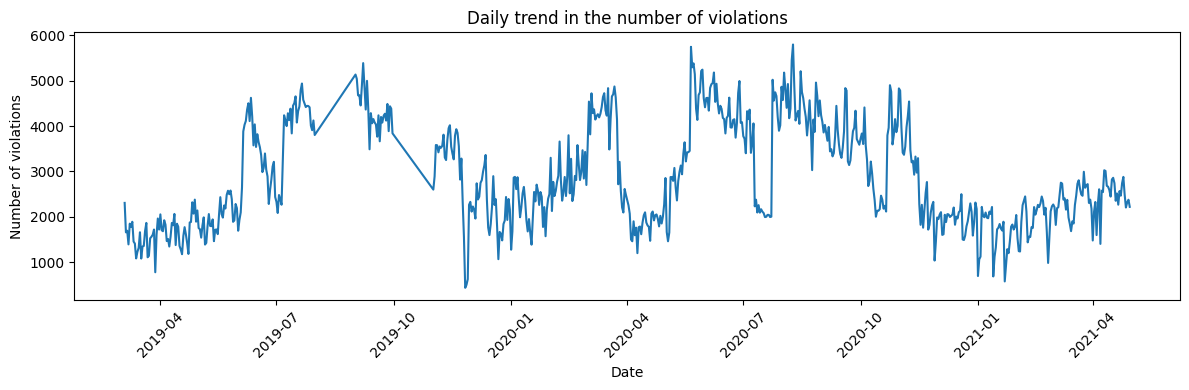

In [23]:
daily_counts = (
    df
    .groupby('normalized_date')   
    .size()                      
    .reset_index(name='n_violations')  
)
plt.figure(figsize=(12, 4))

plt.plot(
    daily_counts['normalized_date'],
    daily_counts['n_violations']
)

plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.title('Daily trend in the number of violations')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

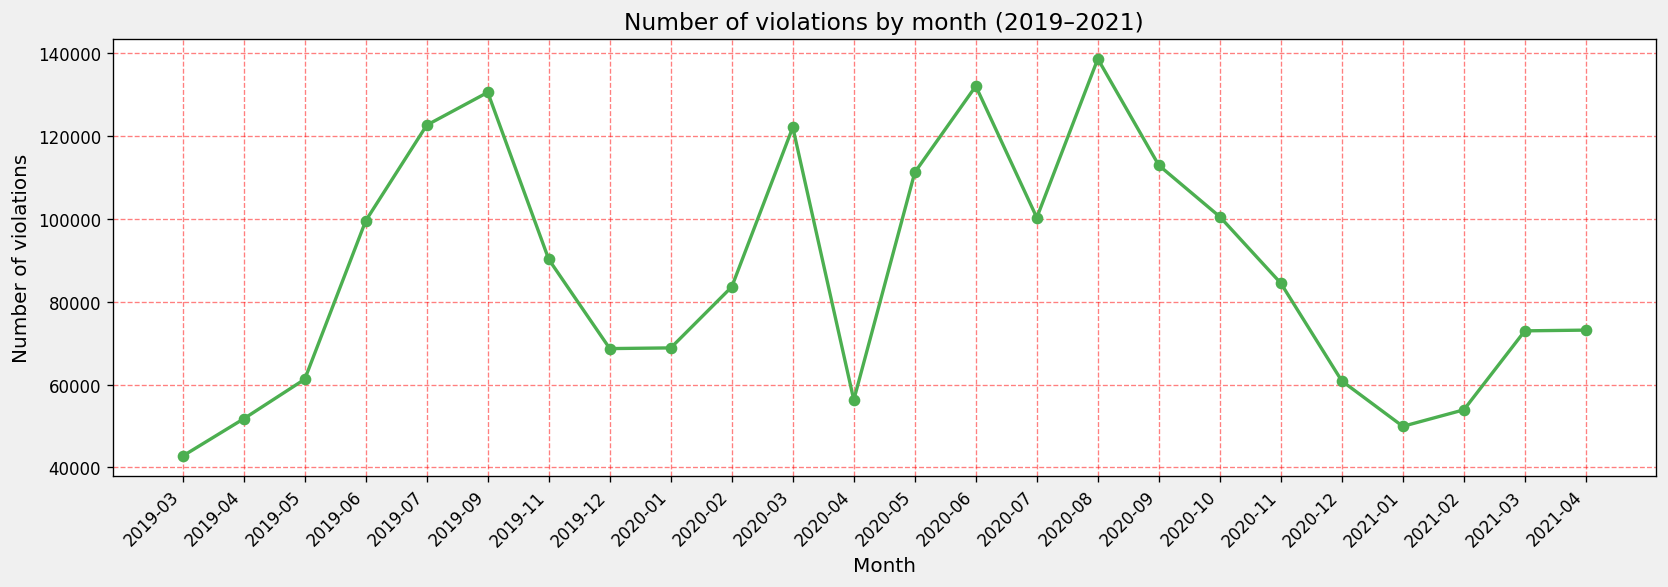

In [24]:
monthly_counts = (
    df
    .groupby(['year', 'month'])
    .size()
    .reset_index(name='n_violations')
    .sort_values(['year', 'month'])
)
monthly_counts['year_month'] = (
    monthly_counts['year'].astype(str)
    + '-'
    + monthly_counts['month'].astype(str).str.zfill(2)  
)

x = range(len(monthly_counts))
y = monthly_counts['n_violations']

fig, ax = plt.subplots(figsize=(14, 5), dpi=120)

fig.patch.set_facecolor('#f0f0f0')

ax.plot(
    x,
    y,
    marker='o',
    linewidth=2,
    color='#4caf50'                 
)

ax.grid(True, linestyle='--', alpha=0.4)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of violations', fontsize=12)
ax.set_title('Number of violations by month (2019–2021)', fontsize=14)

step = max(1, len(monthly_counts) // 20)

ax.set_xticks(x[::step])
ax.set_xticklabels(
    monthly_counts['year_month'].iloc[::step],
    rotation=45,
    ha='right'
)
ax.grid(True, linestyle='--', color='red', alpha=0.5)
plt.tight_layout()
plt.show()

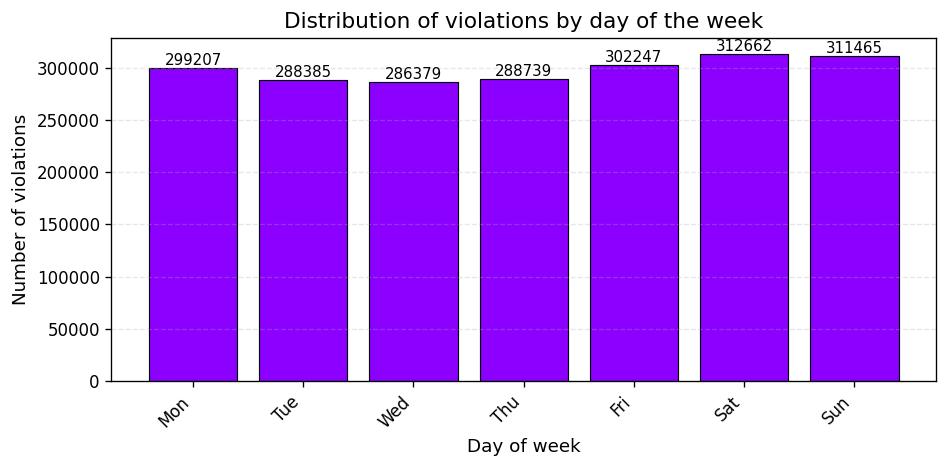

In [25]:
weekday_counts = (
    df
    .groupby(['weekday_name'])
    .size()
    .reset_index(name='n_violations')
    .sort_values('weekday_name')
)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

weekday_counts['weekday_name'] = pd.Categorical(
    weekday_counts['weekday_name'],
    categories=order,
    ordered=True
)

weekday_counts = weekday_counts.sort_values('weekday_name')
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
bars = ax.bar(
    weekday_counts['weekday_name'],
    weekday_counts['n_violations'],
    color='#8B00FF',      
    edgecolor='black',    
    linewidth=0.7
)

ax.set_xlabel('Day of week', fontsize=11)
ax.set_ylabel('Number of violations', fontsize=11)
ax.set_title('Distribution of violations by day of the week', fontsize=13)

plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                             
        f'{int(height)}',                   
        ha='center', va='bottom',          
        fontsize=9
    )

ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


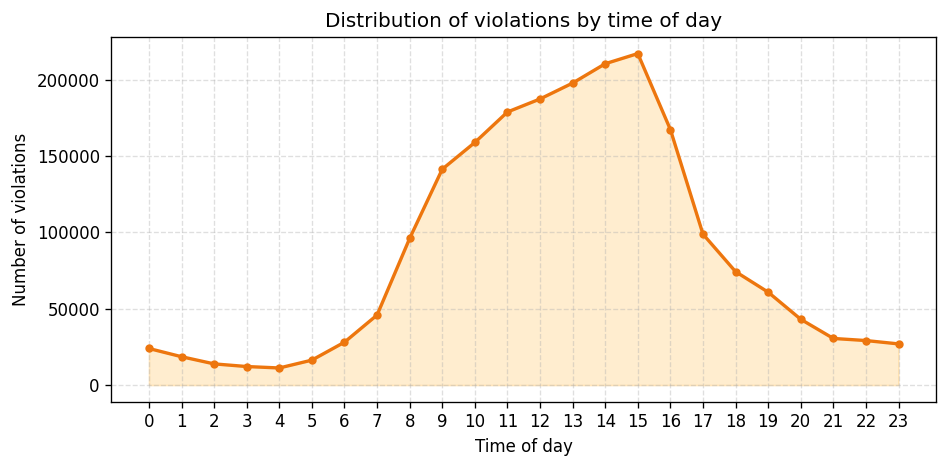

In [26]:
hour_counts = (
    df
    .groupby('hour')
    .size()
    .reset_index(name='n_violations')
    .sort_values('hour')
)

plt.figure(figsize=(8, 4), dpi=120)

x = hour_counts['hour']
y = hour_counts['n_violations']

plt.plot(x, y, marker='o', linewidth=2, color='#ED760E', markersize=4)

plt.fill_between(
    x,
    y,
    alpha=0.25,        
    color='#FFB841'    
)

plt.xlabel('Time of day')
plt.ylabel('Number of violations')
plt.title('Distribution of violations by time of day')

plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

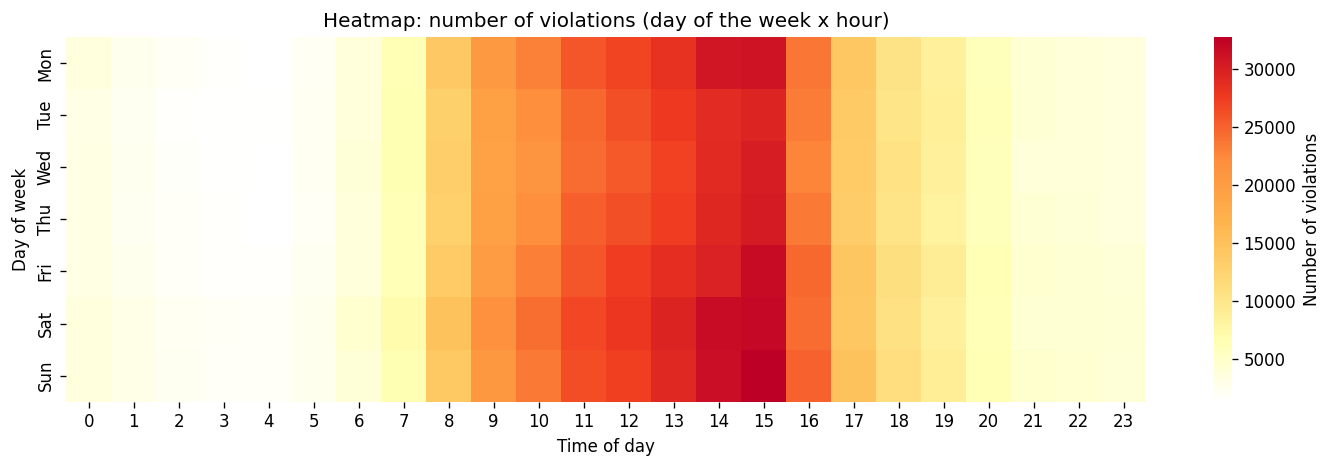

In [27]:
pivot = (
    df
    .groupby(['weekday', 'hour'])
    .size()
    .reset_index(name='n_violations')
    .pivot(index='weekday', columns='hour', values='n_violations')
    .fillna(0)
)

colors = [
    '#ffffff',
    '#ffffb2',
    '#fed976',
    '#feb24c',
    '#fd8d3c',
    '#f03b20',
    '#bd0026'
]
custom_cmap = LinearSegmentedColormap.from_list(
    'white_yellow_orange_red',
    colors
)

weekday_labels = (
    df[['weekday', 'weekday_name']]
    .drop_duplicates()
    .sort_values('weekday')['weekday_name']
    .tolist()
)

pivot_sns = pivot.copy()
pivot_sns.index = weekday_labels  

plt.figure(figsize=(12, 4), dpi=120)

sns.heatmap(
    pivot_sns,
    cmap=custom_cmap,
    cbar_kws={'label': 'Number of violations'}
)

plt.xlabel('Time of day')
plt.ylabel('Day of week')
plt.title('Heatmap: number of violations (day of the week x hour)')

plt.xticks(
    ticks=np.arange(0.5, 24.5),      
    labels=np.arange(0, 24)          
)

plt.tight_layout()
plt.show()


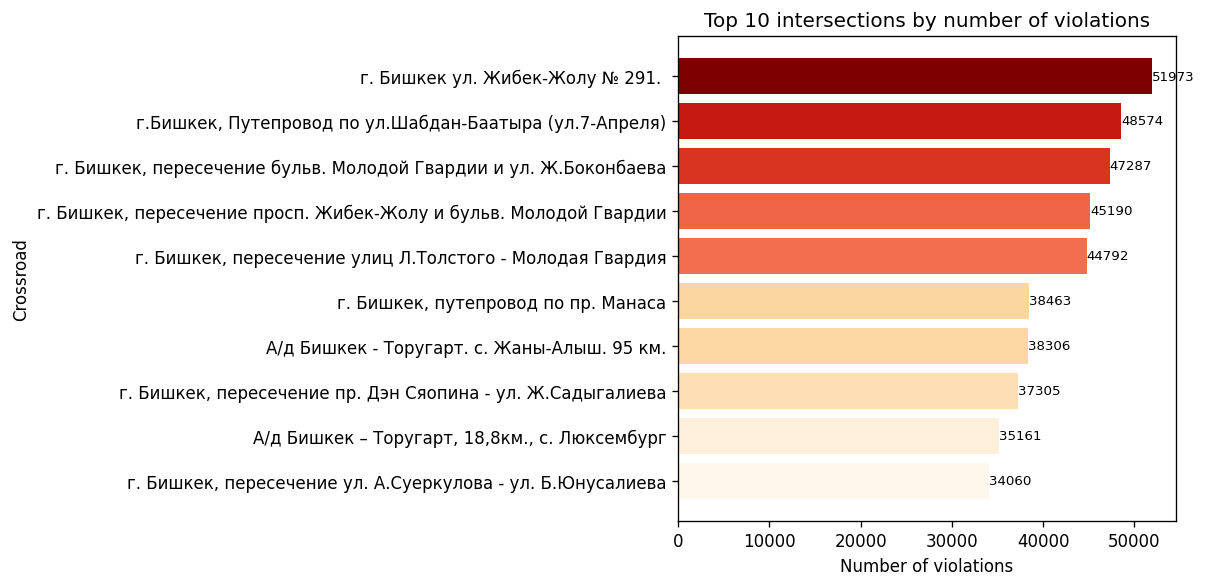

In [28]:
import matplotlib.colors as mcolors

top_crossroads = (
    df['crossroad_name']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  
)

values = top_crossroads.values

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())

cmap = plt.cm.OrRd

colors = cmap(norm(values))

plt.figure(figsize=(10, 5), dpi=120)

plt.barh(top_crossroads.index, top_crossroads.values, color=colors)

plt.xlabel('Number of violations')
plt.ylabel('Crossroad')
plt.title('Top 10 intersections by number of violations')

for i, v in enumerate(top_crossroads.values):
    plt.text(v, i, str(v), va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()


C:\Users\Abay\AppData\Local\Temp\ipykernel_3708\3700407730.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


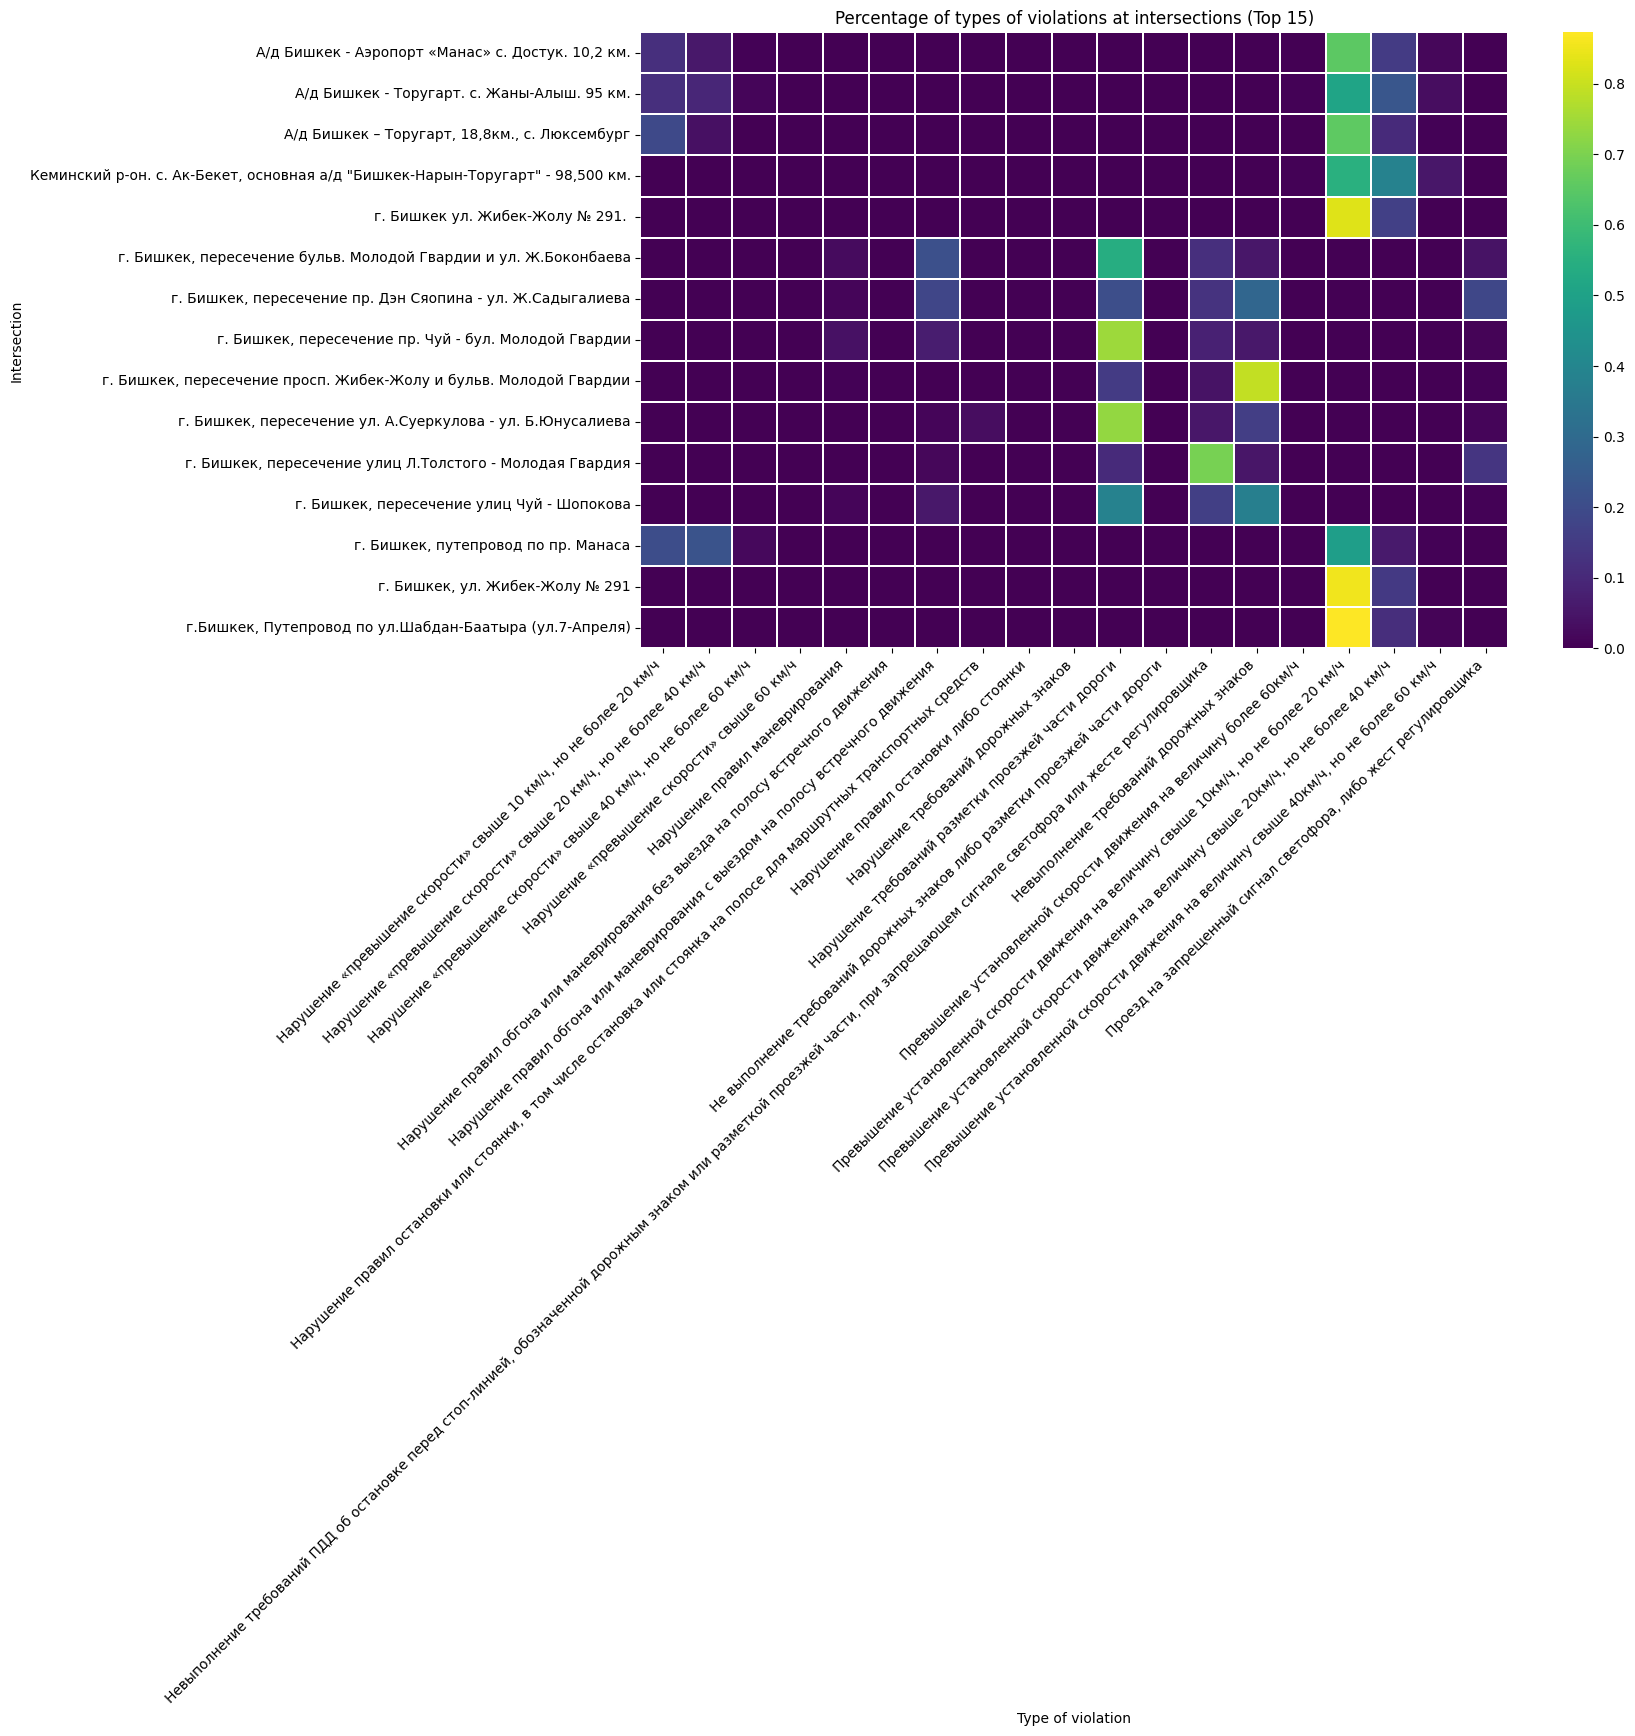

In [29]:
cross_counts = df['crossroad_name'].value_counts()

top_crossroads = cross_counts.head(15).index

df_top = df[df['crossroad_name'].isin(top_crossroads)]

pivot = (
    pd.crosstab(df_top['crossroad_name'], df_top['violation_protocol_name'], normalize='index')
)

plt.figure(figsize=(14, 8))
sns.heatmap(pivot, cmap='viridis', linewidths=0.2)

plt.title('Percentage of types of violations at intersections (Top 15)')
plt.xlabel('Type of violation')
plt.ylabel('Intersection')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

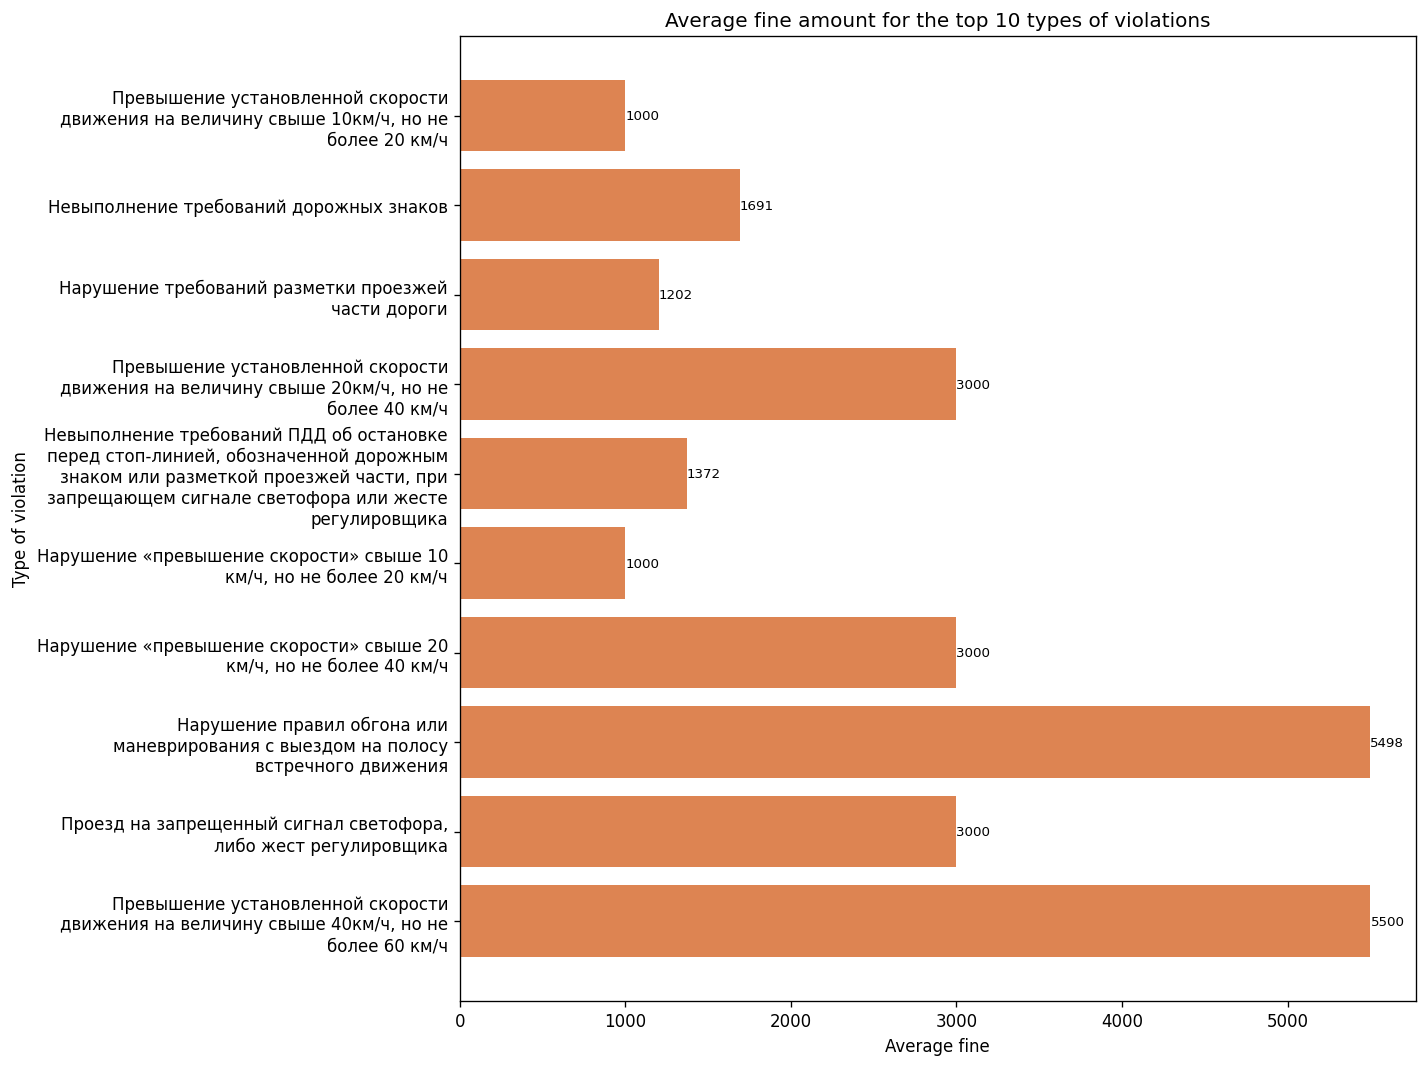

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

top_protos_counts = (
    df['violation_protocol_name']
    .value_counts()
    .head(10)                      
    .sort_values(ascending=True)    
)

top_proto_names = top_protos_counts.index 

proto_mean_fine = (
    df[df['violation_protocol_name'].isin(top_proto_names)]
    .groupby('violation_protocol_name')['violation_ammount']
    .mean()
    .loc[top_proto_names]     
)

wrapped_labels = [textwrap.fill(name, 40) for name in proto_mean_fine.index]

plt.figure(figsize=(12, 9), dpi=120)

y_pos = np.arange(len(proto_mean_fine))

plt.barh(y_pos, proto_mean_fine.values, color='#dd8452')

plt.xlabel('Average fine')
plt.ylabel('Type of violation')
plt.title('Average fine amount for the top 10 types of violations')

plt.yticks(y_pos, wrapped_labels)

for i, v in enumerate(proto_mean_fine.values):
    plt.text(v, i, f'{v:.0f}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [31]:
avg_fines = (
    df.groupby('crossroad_name')['violation_ammount']
    .mean()
    .sort_values(ascending=False)
)
avg_fines

crossroad_name
пересечение улиц Л.Толстого – Бакаева (г. Бишкек, Киргизская Республика)                   3745.192308
г. Бишкек, пересечение улиц Дэн Сяопина - Садыгалиева                                      3638.483965
А/д.Бишкек –Торугарт, 47 км., с.Дружба                                                     3593.750000
А/д Бишкек - Аэропорт «Манас» с. Манас. 23 км                                              3590.551181
г. Бишкек, пересечение улиц Боконбаева - Молодая Гвардия                                   3467.086157
                                                                                              ...     
Чуйский р-он. основная а/д "Бишкек-Нарын-Торугарт" - 71,00 км                              1000.000000
Аламудунский р-он, с. Нижняя Ала-Арча, ул. Киргиская дом № 149                             1000.000000
Объездная а/д. "Бишкек-Нарын-Торугарт" - 24,800 км.                                        1000.000000
Аламудунский р-он. с. Лебединовка пр. Ленина № 187.       

In [32]:
cross_counts = (
    df
    .groupby(['crossroad_name', 'latitude', 'longitude'])
    .size()
    .reset_index(name='n_violations')
    .sort_values('n_violations', ascending=False)
)
cross_counts


,crossroad_name,latitude,longitude,n_violations
0,г. Бишкек ул. Жибек-Жолу № 291.,42.886356,74.625874,51973
19,"г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул....",42.867031,74.636661,48574
1,"г. Бишкек, пересечение бульв. Молодой Гвардии ...",42.868335,74.575132,47287
9,"г. Бишкек, пересечение просп. Жибек-Жолу и бул...",42.884736,74.576391,45190
14,"г. Бишкек, пересечение улиц Л.Толстого - Молод...",42.866329,74.574666,44792
18,"г. Бишкек, путепровод по пр. Манаса",42.866261,74.587268,38463
3,"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж...",42.874280,74.523351,37305
10,"г. Бишкек, пересечение ул. А.Суеркулова - ул. ...",42.835588,74.622127,34060
6,"г. Бишкек, пересечение пр. Чуй - бул. Молодой ...",42.877192,74.575236,31506
16,"г. Бишкек, пересечение улиц Чуй - Шопокова",42.875553,74.615181,30794


Общие координаты центра:
42.875426, 74.603667


In [33]:
import folium

bishkek_center = [42.875426, 74.603667]

m = folium.Map(location=bishkek_center, zoom_start=12, tiles='OpenStreetMap')

subset = cross_counts.sort_values('n_violations', ascending=False)

max_viol = subset['n_violations'].max()

for _, row in subset.iterrows():
    radius = 5 + (row['n_violations'] / max_viol) * 15

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=(
            f"{row['crossroad_name']}<br>"
            f"Violations: {row['n_violations']}"
        )
    ).add_to(m)

m

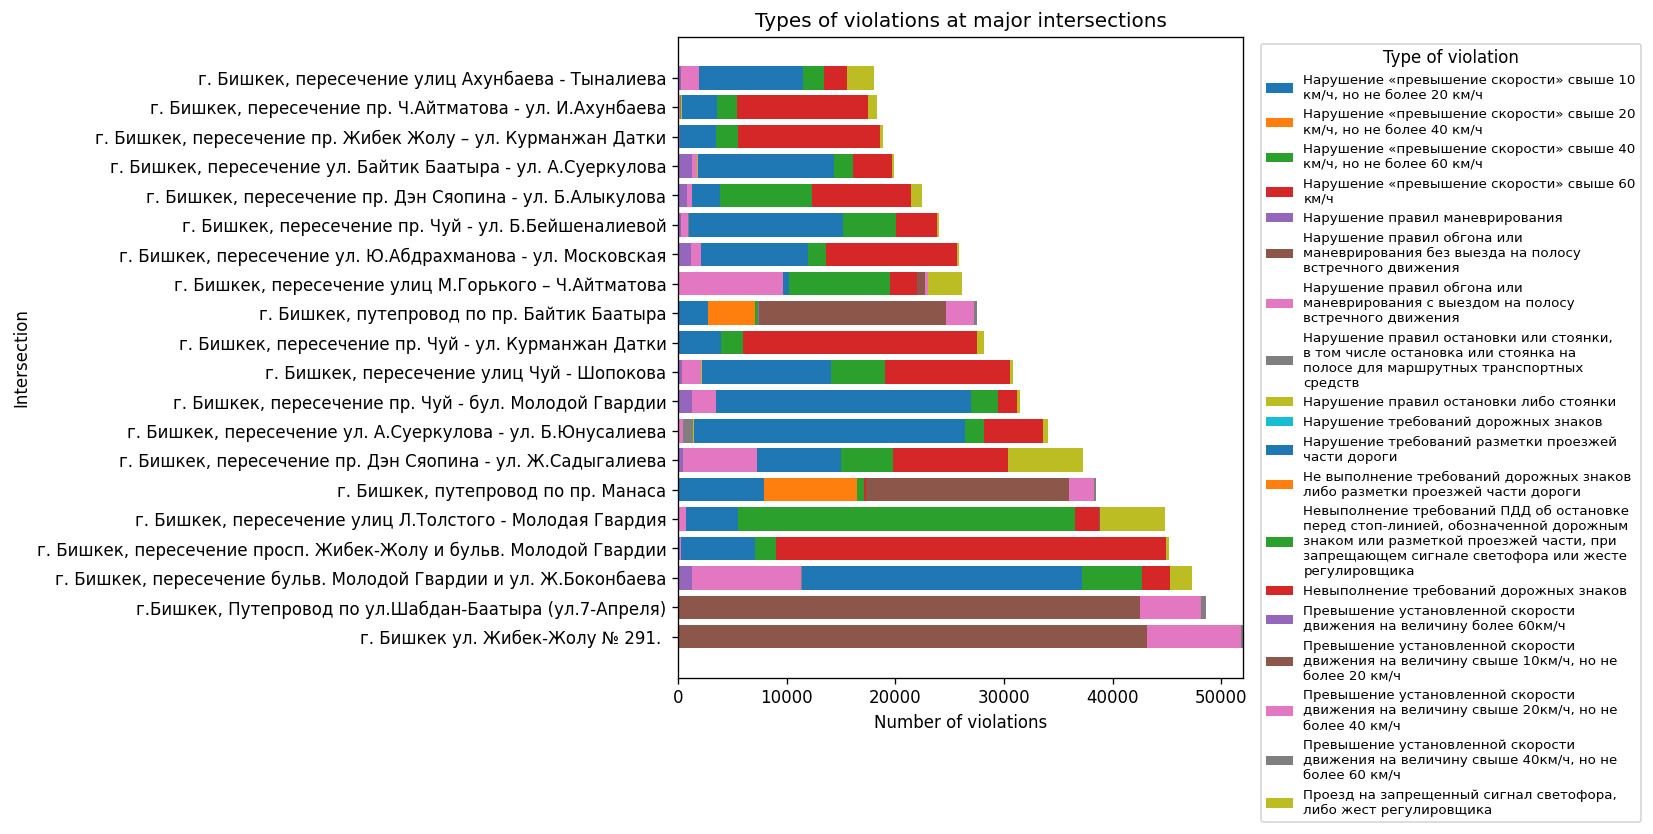

In [34]:
df_filtered = df[df['crossroad_name'].isin(cross_counts['crossroad_name'])]
df_filtered
cross_type_counts = (
    df_filtered
    .groupby(['crossroad_name', 'violation_protocol_name'])
    .size()
    .reset_index(name='n_violations')
)
cross_totals = (
    cross_type_counts
    .groupby('crossroad_name')['n_violations']
    .sum()
    .reset_index(name='total_violations')
    .sort_values('total_violations', ascending=False)
)
cross_type_top = cross_type_counts[
    cross_type_counts['crossroad_name'].isin(cross_totals['crossroad_name'])
].copy()
cross_type_top['share'] = (
        cross_type_top['n_violations'] /
        cross_type_top.groupby('crossroad_name')['n_violations'].transform('sum')
)
dominant_violation = (
    cross_type_top
    .sort_values(['crossroad_name', 'share'], ascending=[True, False])
    .groupby('crossroad_name')
    .head(1)
    .reset_index(drop=True)
)

dominant_violation
pivot_cross_type = (
    cross_type_top
    .pivot(index='crossroad_name',
           columns='violation_protocol_name',
           values='n_violations')
    .fillna(0)
)

pivot_cross_type['total'] = pivot_cross_type.sum(axis=1)
pivot_cross_type = pivot_cross_type.sort_values('total', ascending=False)

pivot_plot = pivot_cross_type.drop(columns=['total'])
pivot_plot
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

bottom = np.zeros(len(pivot_plot))

for violation in pivot_plot.columns:
    values = pivot_plot[violation].values
    ax.barh(pivot_plot.index, values, left=bottom, label=violation)
    bottom += values

ax.set_xlabel('Number of violations')
ax.set_ylabel('Intersection')
ax.set_title('Types of violations at major intersections')

handles, labels = ax.get_legend_handles_labels()

wrapped_labels = [
    textwrap.fill(lbl, width=40)
    for lbl in labels
]

ax.legend(
    handles,
    wrapped_labels,
    title='Type of violation',
    fontsize=8,
    bbox_to_anchor=(1.02, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()


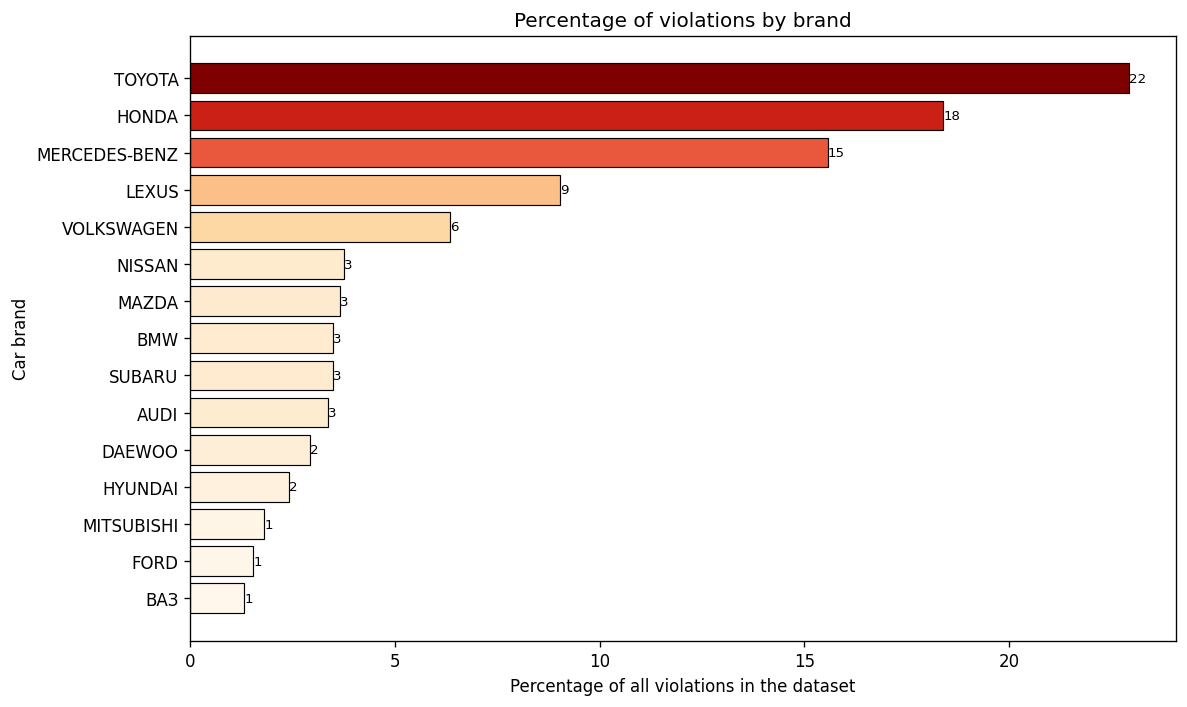

In [35]:

df['car_brand_clean'] = df['car_brand'].fillna('Unknown')

top_brands = (
    df['car_brand_clean']
    .value_counts()
    .head(15)                   
    .sort_values(ascending=True) 
)

values =  (
    top_brands / top_brands.sum()
).sort_values(ascending=True)
brands = top_brands.index

norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())
cmap = plt.cm.OrRd
colors = cmap(norm(values))

fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

bars = ax.barh(brands, values*100, color=colors, edgecolor='black', linewidth=0.7)

ax.set_xlabel('Percentage of all violations in the dataset')
ax.set_ylabel('Car brand')
ax.set_title('Percentage of violations by brand')

for bar in bars:
    w = bar.get_width()
    ax.text(w, bar.get_y() + bar.get_height()/2,
            f'{int(w)}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [36]:
pivot = pd.crosstab(df['crossroad_name'], df['violation_protocol_name'])
agg = df.groupby('crossroad_name').agg(
    total_violations = ('violation_protocol_name','count'),
    avg_fine = ('violation_ammount','mean')
)
profile = pivot.join(agg).fillna(0)
profile = profile[profile['total_violations'] >= 10]
features = profile.drop(columns=[])
X = features.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = km.fit_predict(X_scaled)
profile['cluster'] = labels
profile.reset_index().to_csv('crossroad_clusters.csv', index=False)

In [38]:
cluster_df = pd.read_csv('crossroad_clusters.csv')
cluster_df

,crossroad_name,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
0,"52,00 км. Объездная а/д ""Бишкек-Нарын-Торугарт""",0,0,0,0,0,0,0,0,0,...,0,0,0,66,35,9,0,110,2004.545455,2
1,"76,00 км. Объездная, а/д ""Бишкек-Нарын-Торугарт""",0,0,0,0,0,0,0,0,0,...,0,0,0,36,7,5,0,48,1760.416667,2
2,А/д «Бишкек-Кара-Балта-Чалдовар-граница с Респ...,230,73,6,0,0,0,0,0,0,...,0,0,1,1307,256,10,0,1883,1391.131174,2
3,"А/д Биш. Торугарт, 20км., с. Люксембург",773,245,15,0,0,0,0,0,0,...,0,0,7,5223,972,32,0,7267,1370.304114,2
4,А/д Бишкек - Ош. 78км,1183,1306,113,12,0,0,0,0,0,...,0,0,11,4747,1601,118,0,9091,1770.322297,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,"г.Токмок 63,800 км. основная а/д Бишкек-Нарын-...",13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,14,1142.857143,2
517,"г.Токмок 64,700 км. основная а/д ""Бишкек-Нарын...",149,47,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,204,1637.254902,2
518,"г.Токмок 64,900 км объездная а/д Бишкек-Нарын-...",46,22,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,69,1702.898551,2
519,"объездная, а/д ""Бишкек-Нарын-Торугарт"" - 44,30...",0,0,0,0,0,0,0,0,0,...,0,0,0,64,6,0,0,70,1171.428571,2


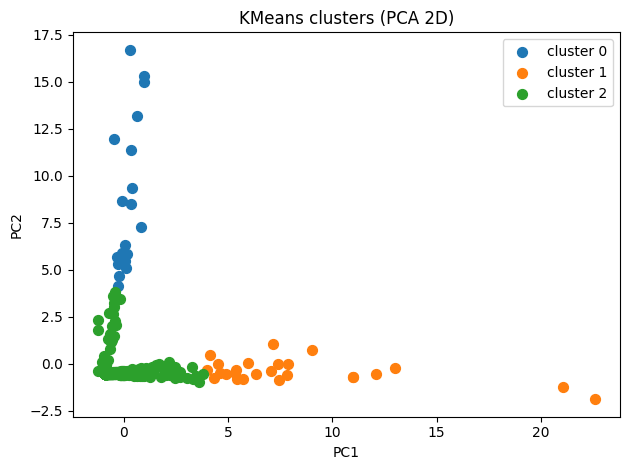


Cluster 0 - top intersections by number of violations:


,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,"Нарушение правил проезда пешеходных переходов, движение по тротуарам",...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
crossroad_name,,,,,,,,,,,,,,,,,,,,,
"г. Бишкек, пересечение бульв. Молодой Гвардии и ул. Ж.Боконбаева",0,0,0,0,1269,0,10081,16,2,0,...,5570,2567,0,0,0,0,2008,47287,2205.162095,0
"г. Бишкек, пересечение просп. Жибек-Жолу и бульв. Молодой Гвардии",0,0,0,0,169,0,64,1,3,0,...,1906,35896,0,0,0,0,284,45190,1165.302058,0
"г. Бишкек, пересечение улиц Л.Толстого - Молодая Гвардия",9,0,0,0,111,1,644,0,0,0,...,31054,2184,0,80,7,0,5988,44792,1399.736560,0
"г. Бишкек, пересечение пр. Дэн Сяопина - ул. Ж.Садыгалиева",0,0,0,0,472,0,6751,1,1,0,...,4796,10626,0,0,0,0,6920,37305,2345.436269,0
"г. Бишкек, пересечение ул. А.Суеркулова - ул. Б.Юнусалиева",0,0,0,0,52,0,373,948,74,0,...,1760,5436,0,0,0,0,459,34060,1167.601292,0



Cluster 1 - top intersections by number of violations:


,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,"Нарушение правил проезда пешеходных переходов, движение по тротуарам",...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
crossroad_name,,,,,,,,,,,,,,,,,,,,,
г. Бишкек ул. Жибек-Жолу № 291.,0,0,0,0,0,0,0,0,0,0,...,0,0,4,43150,8667,152,0,51973,1347.180267,1
"г.Бишкек, Путепровод по ул.Шабдан-Баатыра (ул.7-Апреля)",0,0,0,0,0,0,0,0,0,0,...,0,0,109,42405,5628,432,0,48574,1286.336312,1
"г. Бишкек, путепровод по пр. Манаса",7863,8608,678,104,0,0,0,0,0,0,...,0,2,32,18666,2355,155,0,38463,1690.598757,1
А/д Бишкек - Торугарт. с. Жаны-Алыш. 95 км.,4563,3536,406,52,0,0,0,0,0,0,...,0,0,205,19505,8902,1137,0,38306,1874.275570,1
"А/д Бишкек – Торугарт, 18,8км., с. Люксембург",6792,1264,70,6,0,0,0,0,0,0,...,0,0,19,23129,3695,186,0,35161,1319.459060,1



Cluster 2 - top intersections by number of violations:


,"Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч","Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч","Нарушение «превышение скорости» свыше 40 км/ч, но не более 60 км/ч",Нарушение «превышение скорости» свыше 60 км/ч,Нарушение правил маневрирования,Нарушение правил обгона или маневрирования без выезда на полосу встречного движения,Нарушение правил обгона или маневрирования с выездом на полосу встречного движения,"Нарушение правил остановки или стоянки, в том числе остановка или стоянка на полосе для маршрутных транспортных средств",Нарушение правил остановки либо стоянки,"Нарушение правил проезда пешеходных переходов, движение по тротуарам",...,"Невыполнение требований ПДД об остановке перед стоп-линией, обозначенной дорожным знаком или разметкой проезжей части, при запрещающем сигнале светофора или жесте регулировщика",Невыполнение требований дорожных знаков,Превышение установленной скорости движения на величину более 60км/ч,"Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч","Превышение установленной скорости движения на величину свыше 20км/ч, но не более 40 км/ч","Превышение установленной скорости движения на величину свыше 40км/ч, но не более 60 км/ч","Проезд на запрещенный сигнал светофора, либо жест регулировщика",total_violations,avg_fine,cluster
crossroad_name,,,,,,,,,,,,,,,,,,,,,
г. Бишкек ул. Жибек-Жолу № 291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,17661,2962,51,0,20674,1297.644384,2
"г. Бишкек, пересечение пр. Жибек Жолу – ул. Курманжан Датки",0,0,0,0,146,0,34,0,14,0,...,2093,13057,0,0,0,0,259,18874,1513.457667,2
"г. Бишкек, ул. Жибек-Жолу дом № 291",0,0,0,0,0,0,0,0,0,0,...,0,0,0,14997,2494,41,0,17532,1295.031942,2
"Аламудунский р-он. с. Аламудун ул. Алма-Атинская № 472, а/д ""Бишкек-Кордай"" - 9,00 км.",0,0,0,0,0,0,0,0,0,0,...,0,0,10,13619,3171,128,0,16928,1412.511815,2
"г. Бишкек, пересечение улиц Жибек Жолу - Абдрахманова",0,0,0,0,0,0,13,0,2,0,...,671,15227,0,0,0,0,19,16035,3002.026816,2


In [39]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
for cl in sorted(np.unique(labels)):
    idx = labels == cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'cluster {cl}', s=50)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('KMeans clusters (PCA 2D)')
plt.legend(); plt.tight_layout(); plt.show()
for cl in sorted(profile['cluster'].unique()):
    print(f"\nCluster {cl} - top intersections by number of violations:")
    display(profile[profile['cluster']==cl].sort_values('total_violations', ascending=False).head(5))

In [40]:
features = [
    'car_brand',
    'car_model',
    'crossroad_name',
    'violation_protocol_name',
    'hour',
    'weekday',
    'month'
]
target = 'violation_ammount'
X = df[features]
y = df[target]

categorical = ['car_brand', 'car_model', 'crossroad_name',
               'violation_protocol_name', 'weekday']
numeric = ['hour', 'month']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('regressor', Ridge(alpha=1.0))
])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
y_train

493110     1000
1626195    1000
1551940    1000
410895     1000
1038857    1000
           ... 
259178     1000
1414414    1000
131932     1000
671155     3000
121958     1000
Name: violation_ammount, Length: 1566813, dtype: int64

In [60]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [61]:
y_pred = model.predict(X_test)

In [63]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regression results:")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.3f}")

Regression results:
MAE: 126.36
R^2: 0.919


In [65]:
features = [
    'car_brand',
    'car_model',
    'crossroad_name',
    'violation_protocol_name',
    'hour',
    'weekday',
    'month'
]
target = 'violation_protocol_name'

X = df[features]
y = df[target]

categorical = ['car_brand', 'car_model', 'crossroad_name', 'weekday']
numeric = ['hour', 'month']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(
        max_iter=500,
        multi_class='multinomial',   # softmax multiclass
        solver='lbfgs'
    ))
])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train

,car_brand,car_model,crossroad_name,violation_protocol_name,hour,weekday,month
704613,HONDA,CR-V,"г. Бишкек, пересечение улиц Чуй - Курманжан Датка",Невыполнение требований дорожных знаков,17,4,5
793886,TOYOTA,WISH,"А/д Бишкек – Торугарт, 18,8км., с. Люксембург",Превышение установленной скорости движения на ...,9,3,5
1411940,MERCEDES-BENZ,E 320,"Кеминский р-он. с. Ак-Бекет, основная а/д ""Биш...",Превышение установленной скорости движения на ...,13,1,8
1660689,TOYOTA,IPSUM,"г. Бишкек, пересечение улиц Б.Алыкулова – М.Ом...",Нарушение требований разметки проезжей части д...,17,3,9
1706677,LEXUS,LX 470,А/д Бишкек - Аэропорт «Манас» Путепровод. 13 км.,Превышение установленной скорости движения на ...,3,2,10
...,...,...,...,...,...,...,...
1181061,KIA,RIO,"г. Бишкек, пересечение пр. Чуй - ул. Курманжан...",Невыполнение требований дорожных знаков,18,4,7
465317,LAND ROVER,RANGE ROVER,"г. Бишкек, пересечение ул. Ю.Абдрахманова - ул...",Нарушение требований разметки проезжей части д...,17,5,3
1129901,LEXUS,RX 300,"А/д.Бишкек –Торугарт, 47 км., с.Дружба","Нарушение «превышение скорости» свыше 20 км/ч,...",13,0,7
291843,VOLKSWAGEN,PASSAT,"А/д Бишкек –Торугарт 10,3км","Нарушение «превышение скорости» свыше 40 км/ч,...",11,2,3


In [69]:
model.fit(X_train, y_train)

C:\Users\Abay\AppData\Local\Programs\Python\Python39\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Abay\AppData\Local\Programs\Python\Python39\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [70]:
y_pred = model.predict(X_test)

In [75]:
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Results:")
print(f"Accuracy: {acc:.3f}\n")

Logistic Regression Results:
Accuracy: 0.632



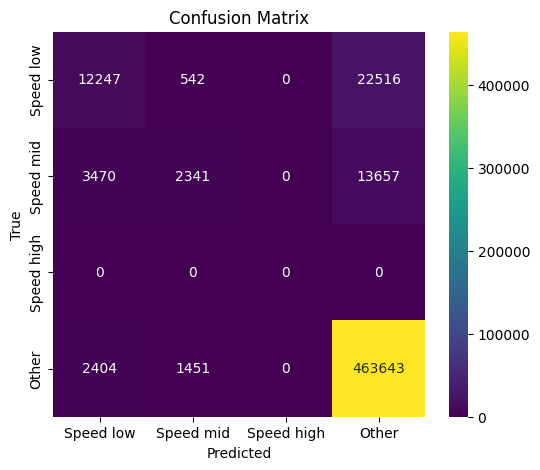

In [ ]:
label_map = {
    'Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч': 'Speed low',
    'Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч': 'Speed mid',
    'Нарушение «превышение скорости» свыше 40 км/ч': 'Speed high',
}

y_test_custom = y_test.map(lambda x: label_map.get(x, 'Other'))
y_pred_custom = pd.Series(y_pred, index=y_test.index).map(lambda x: label_map.get(x, 'Other'))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_custom, y_pred_custom, labels=['Speed low','Speed mid','Speed high','Other'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Speed low','Speed mid','Speed high','Other'],
            yticklabels=['Speed low','Speed mid','Speed high','Other'],
            cmap='viridis')

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [43]:
cross = df['crossroad_name'].astype(str)

mask_bishkek = cross.str.contains('Бишкек', case=False, na=False)

mask_ad = cross.str.contains('А/д', case=False, na=False)

df_bishkek = df[mask_bishkek & ~mask_ad].copy()
agg = (
    df_bishkek
    .groupby(['crossroad_name', 'year', 'day', 'month', 'weekday', 'hour'])
    .agg(
        n_violations=('id', 'count'),
        top_violation_type=('violation_protocol_name',
                            lambda x: x.value_counts().idxmax())
    )
    .reset_index()
)
agg = agg.sample(n=50000, random_state = 42)
agg.shape

(50000, 8)

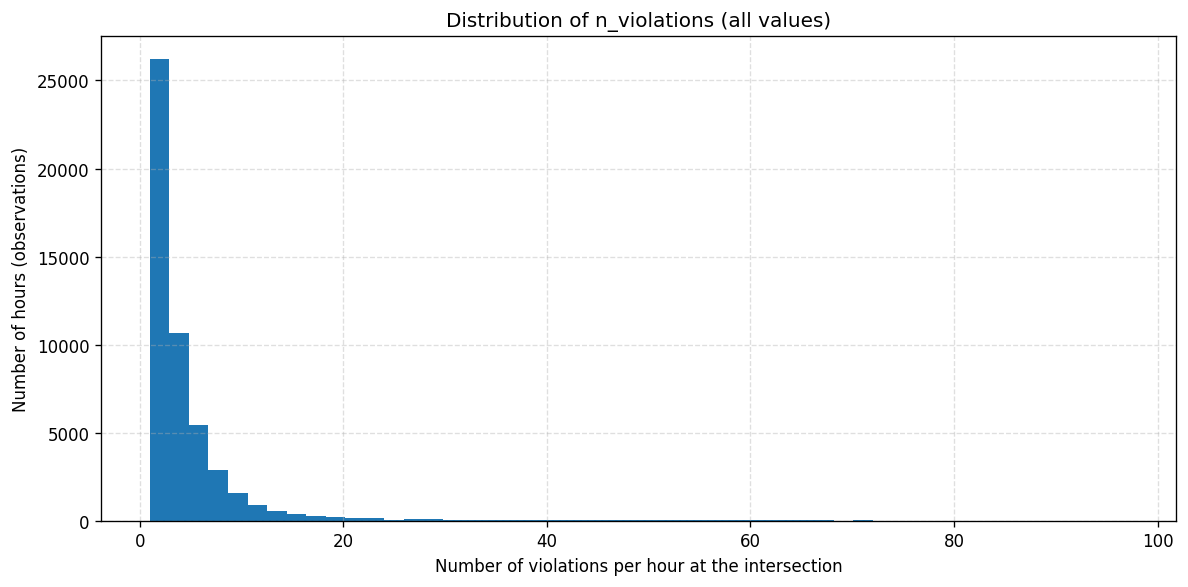

In [44]:
values = agg['n_violations']

fig, ax = plt.subplots(figsize=(10, 5), dpi=120)

ax.hist(values, bins=50)

ax.set_xlabel('Number of violations per hour at the intersection')
ax.set_ylabel('Number of hours (observations)')
ax.set_title('Distribution of n_violations (all values)')

ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

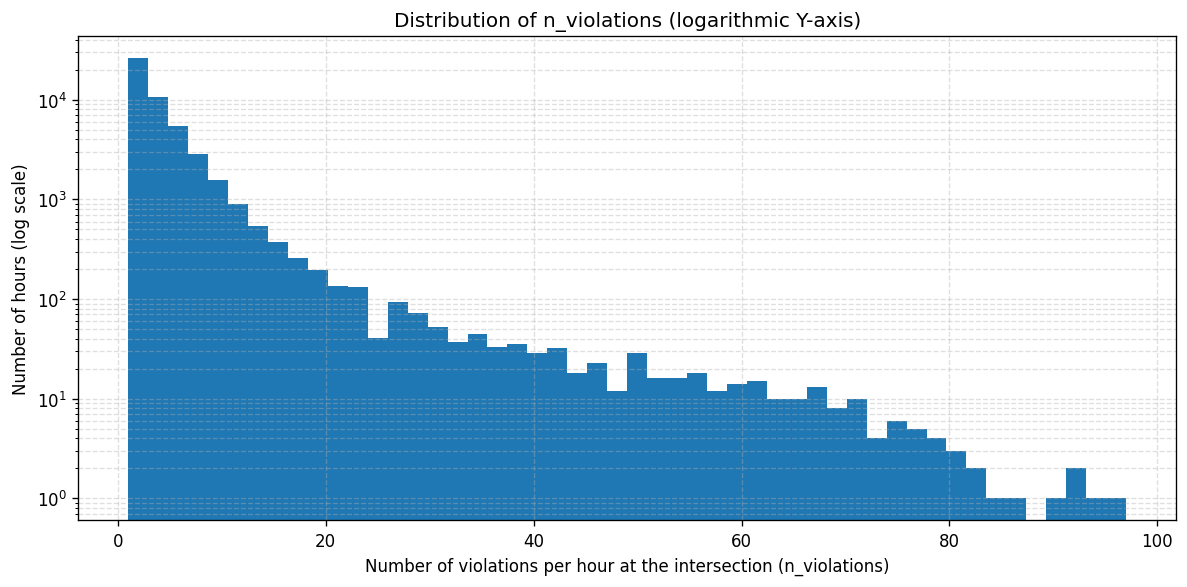

In [45]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)

ax.hist(values, bins=50)

ax.set_xlabel('Number of violations per hour at the intersection (n_violations)')
ax.set_ylabel('Number of hours (log scale)')
ax.set_title('Distribution of n_violations (logarithmic Y-axis)')

ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

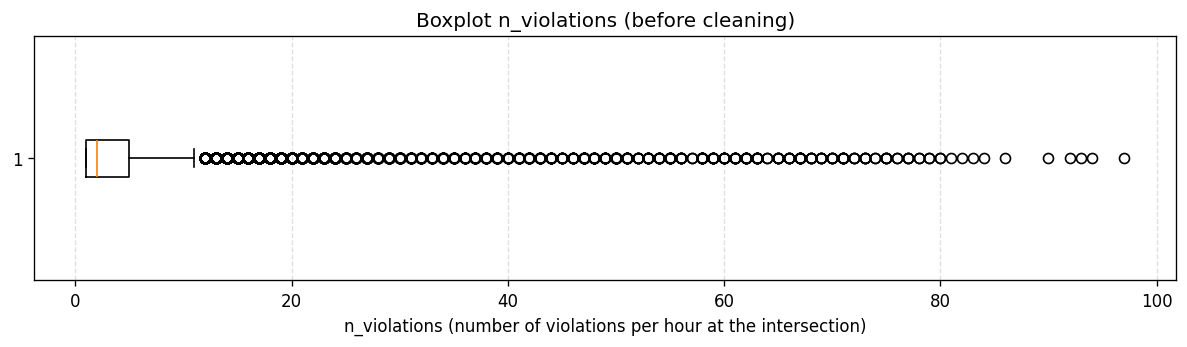

In [46]:
values = agg['n_violations']

fig, ax = plt.subplots(figsize=(10, 3), dpi=120)

ax.boxplot(values, vert=False, showfliers=True)

ax.set_xlabel('n_violations (number of violations per hour at the intersection)')
ax.set_title('Boxplot n_violations (before cleaning)')

ax.grid(True, axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [47]:
values = agg['n_violations'].values

q99 = np.quantile(values, 0.98)
print("98th percentile:", q99)

agg_trim = agg[agg['n_violations'] <= q99].copy()

print("Before:", agg.shape, "After:", agg_trim.shape)


98th percentile: 20.0
Before: (50000, 8) After: (49008, 8)


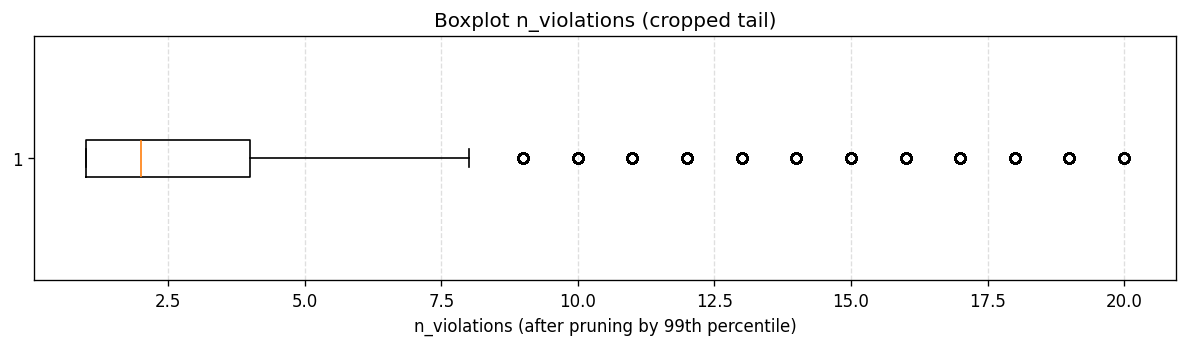

In [48]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=120)
ax.boxplot(agg_trim['n_violations'], vert=False, showfliers=True)

ax.set_xlabel('n_violations (after pruning by 99th percentile)')
ax.set_title('Boxplot n_violations (cropped tail)')
ax.grid(True, axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [49]:
q1 = np.percentile(values, 25)
q3 = np.percentile(values, 75)
iqr = q3 - q1

upper_bound_soft = q3 + 3 * iqr

agg_soft = agg[agg['n_violations'] <= upper_bound_soft].copy()

print("Soft upper border:", upper_bound_soft)
print("Before", agg.shape, "After:", agg_soft.shape)


Soft upper border: 17.0
Before (50000, 8) After: (48680, 8)


In [50]:
threshold = agg['n_violations'].quantile(0.7)
agg['is_high_load'] = (agg['n_violations'] >= threshold).astype(int)

threshold, agg['is_high_load'].value_counts()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X = agg[['crossroad_name', 'month', 'weekday', 'hour']]
y = agg['is_high_load']

cat_features = ['crossroad_name', 'month', 'weekday', 'hour']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

model_highload = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

clf_highload = Pipeline(
    steps=[
        ('preprocess', preprocess),
        ('model', model_highload)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf_highload.fit(X_train, y_train)

from sklearn.metrics import classification_report

y_pred = clf_highload.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      6495
           1       0.64      0.53      0.58      3505

    accuracy                           0.73     10000
   macro avg       0.70      0.68      0.69     10000
weighted avg       0.72      0.73      0.72     10000



In [51]:
y_type = agg['top_violation_type'].copy()

top_types = y_type.value_counts().head(10).index
mask = y_type.isin(top_types)

agg_type = agg[mask].copy()
y_type = agg_type['top_violation_type']

X_type = agg_type[['crossroad_name', 'month', 'weekday', 'hour']]

preprocess_type = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'),
         ['crossroad_name', 'month', 'weekday', 'hour'])
    ]
)

model_type = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

clf_type = Pipeline(
    steps=[
        ('preprocess', preprocess_type),
        ('model', model_type)
    ]
)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_type, y_type, test_size=0.2, random_state=42, stratify=y_type
)

clf_type.fit(X_train_t, y_train_t)

from sklearn.metrics import classification_report

y_pred_t = clf_type.predict(X_test_t)
print(classification_report(y_test_t, y_pred_t))

                                                                                                                                                                                  precision    recall  f1-score   support

                                                                                                              Нарушение «превышение скорости» свыше 10 км/ч, но не более 20 км/ч       0.73      0.75      0.74       393
                                                                                                              Нарушение «превышение скорости» свыше 20 км/ч, но не более 40 км/ч       0.43      0.28      0.34       199
                                                                                                                                                 Нарушение правил маневрирования       0.13      0.06      0.09       155
                                                                                              Нарушение правил обгона или манев

In [52]:
sample = {
    'crossroad_name': ['Чуй × Манаса'],
    'month': [10],
    'weekday': [4],
    'hour': [18]
}

import pandas as pd
sample_df = pd.DataFrame(sample)

highload_pred = clf_highload.predict(sample_df)[0]
type_pred = clf_type.predict(sample_df)[0]

print("High violation load?", bool(highload_pred))
print("Expected dominant type of violation:", type_pred)


High violation load? False
Expected dominant type of violation: Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч


In [53]:
sample = {
    'crossroad_name': ['Чуй × Манаса'],
    'month': [10],
    'weekday': [4],
    'hour': [18]
}

import pandas as pd
sample_df = pd.DataFrame(sample)

highload_pred = clf_highload.predict(sample_df)[0]
type_pred = clf_type.predict(sample_df)[0]

print("High violation load?", bool(highload_pred))
print("Expected dominant type of violation:", type_pred)


High violation load? False
Expected dominant type of violation: Превышение установленной скорости движения на величину свыше 10км/ч, но не более 20 км/ч


In [54]:
clf_highload = Pipeline(
    steps=[
        ('preprocess', preprocess),   # OneHotEncoder
        ('model', model_highload)     # RandomForestClassifier
    ]
)
import pandas as pd
import numpy as np

encoder = clf_highload.named_steps['preprocess'].named_transformers_['cat']
rf_model = clf_highload.named_steps['model']

cat_features = ['crossroad_name', 'month', 'weekday', 'hour']
feature_names = encoder.get_feature_names_out(cat_features)

importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

fi_df = fi_df.sort_values('importance', ascending=False)

fi_df.head(20)


,feature,importance
214,weekday_0,0.025876
218,weekday_4,0.025868
217,weekday_3,0.025734
216,weekday_2,0.025681
215,weekday_1,0.025645
220,weekday_6,0.025592
219,weekday_5,0.025413
204,month_3,0.020400
208,month_7,0.017735
210,month_9,0.017444


In [55]:
def base_feature_name(full_name: str) -> str:
    if full_name.startswith('crossroad_name'):
        return 'crossroad_name'
    elif full_name.startswith('month'):
        return 'month'
    elif full_name.startswith('weekday'):
        return 'weekday'
    elif full_name.startswith('hour'):
        return 'hour'
    else:
        return 'other'

fi_df['base_feature'] = fi_df['feature'].apply(base_feature_name)

fi_grouped = (
    fi_df
    .groupby('base_feature')['importance']
    .sum()
    .reset_index()
    .sort_values('importance', ascending=False)
)

fi_grouped


,base_feature,importance
0,crossroad_name,0.457059
2,month,0.183438
3,weekday,0.179810
1,hour,0.179692


In [56]:
encoder_t = clf_type.named_steps['preprocess'].named_transformers_['cat']
rf_model_t = clf_type.named_steps['model']

feature_names_t = encoder_t.get_feature_names_out(['crossroad_name', 'month', 'weekday', 'hour'])
importances_t = rf_model_t.feature_importances_

fi_type_df = pd.DataFrame({
    'feature': feature_names_t,
    'importance': importances_t
}).sort_values('importance', ascending=False)

fi_type_df.head(20)


,feature,importance
199,"crossroad_name_г.Бишкек, Путепровод по ул.Шабд...",0.026220
209,month_7,0.022767
219,weekday_4,0.021256
220,weekday_5,0.020738
217,weekday_2,0.020557
221,weekday_6,0.020451
218,weekday_3,0.020351
215,weekday_0,0.020345
216,weekday_1,0.020238
2,crossroad_name_Основная автодорога Бишкек - То...,0.019825


In [57]:
fi_type_df['base_feature'] = fi_type_df['feature'].apply(base_feature_name)

fi_type_grouped = (
    fi_type_df
    .groupby('base_feature')['importance']
    .sum()
    .reset_index()
    .sort_values('importance', ascending=False)
)

fi_type_grouped


,base_feature,importance
0,crossroad_name,0.417702
1,hour,0.259080
2,month,0.179283
3,weekday,0.143936


In [58]:
corr_df = agg[['month', 'weekday', 'hour', 'is_high_load']].corr()

corr_with_target = corr_df['is_high_load'].sort_values(ascending=False)
corr_with_target


is_high_load    1.000000
hour            0.095463
month           0.010738
weekday         0.002960
Name: is_high_load, dtype: float64

[[5441 1054]
 [1650 1855]]


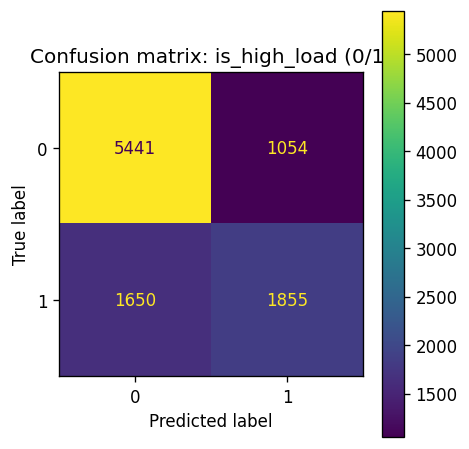

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

print(cm)

fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax, values_format='d')

ax.set_title('Confusion matrix: is_high_load (0/1)')
plt.tight_layout()
plt.show()


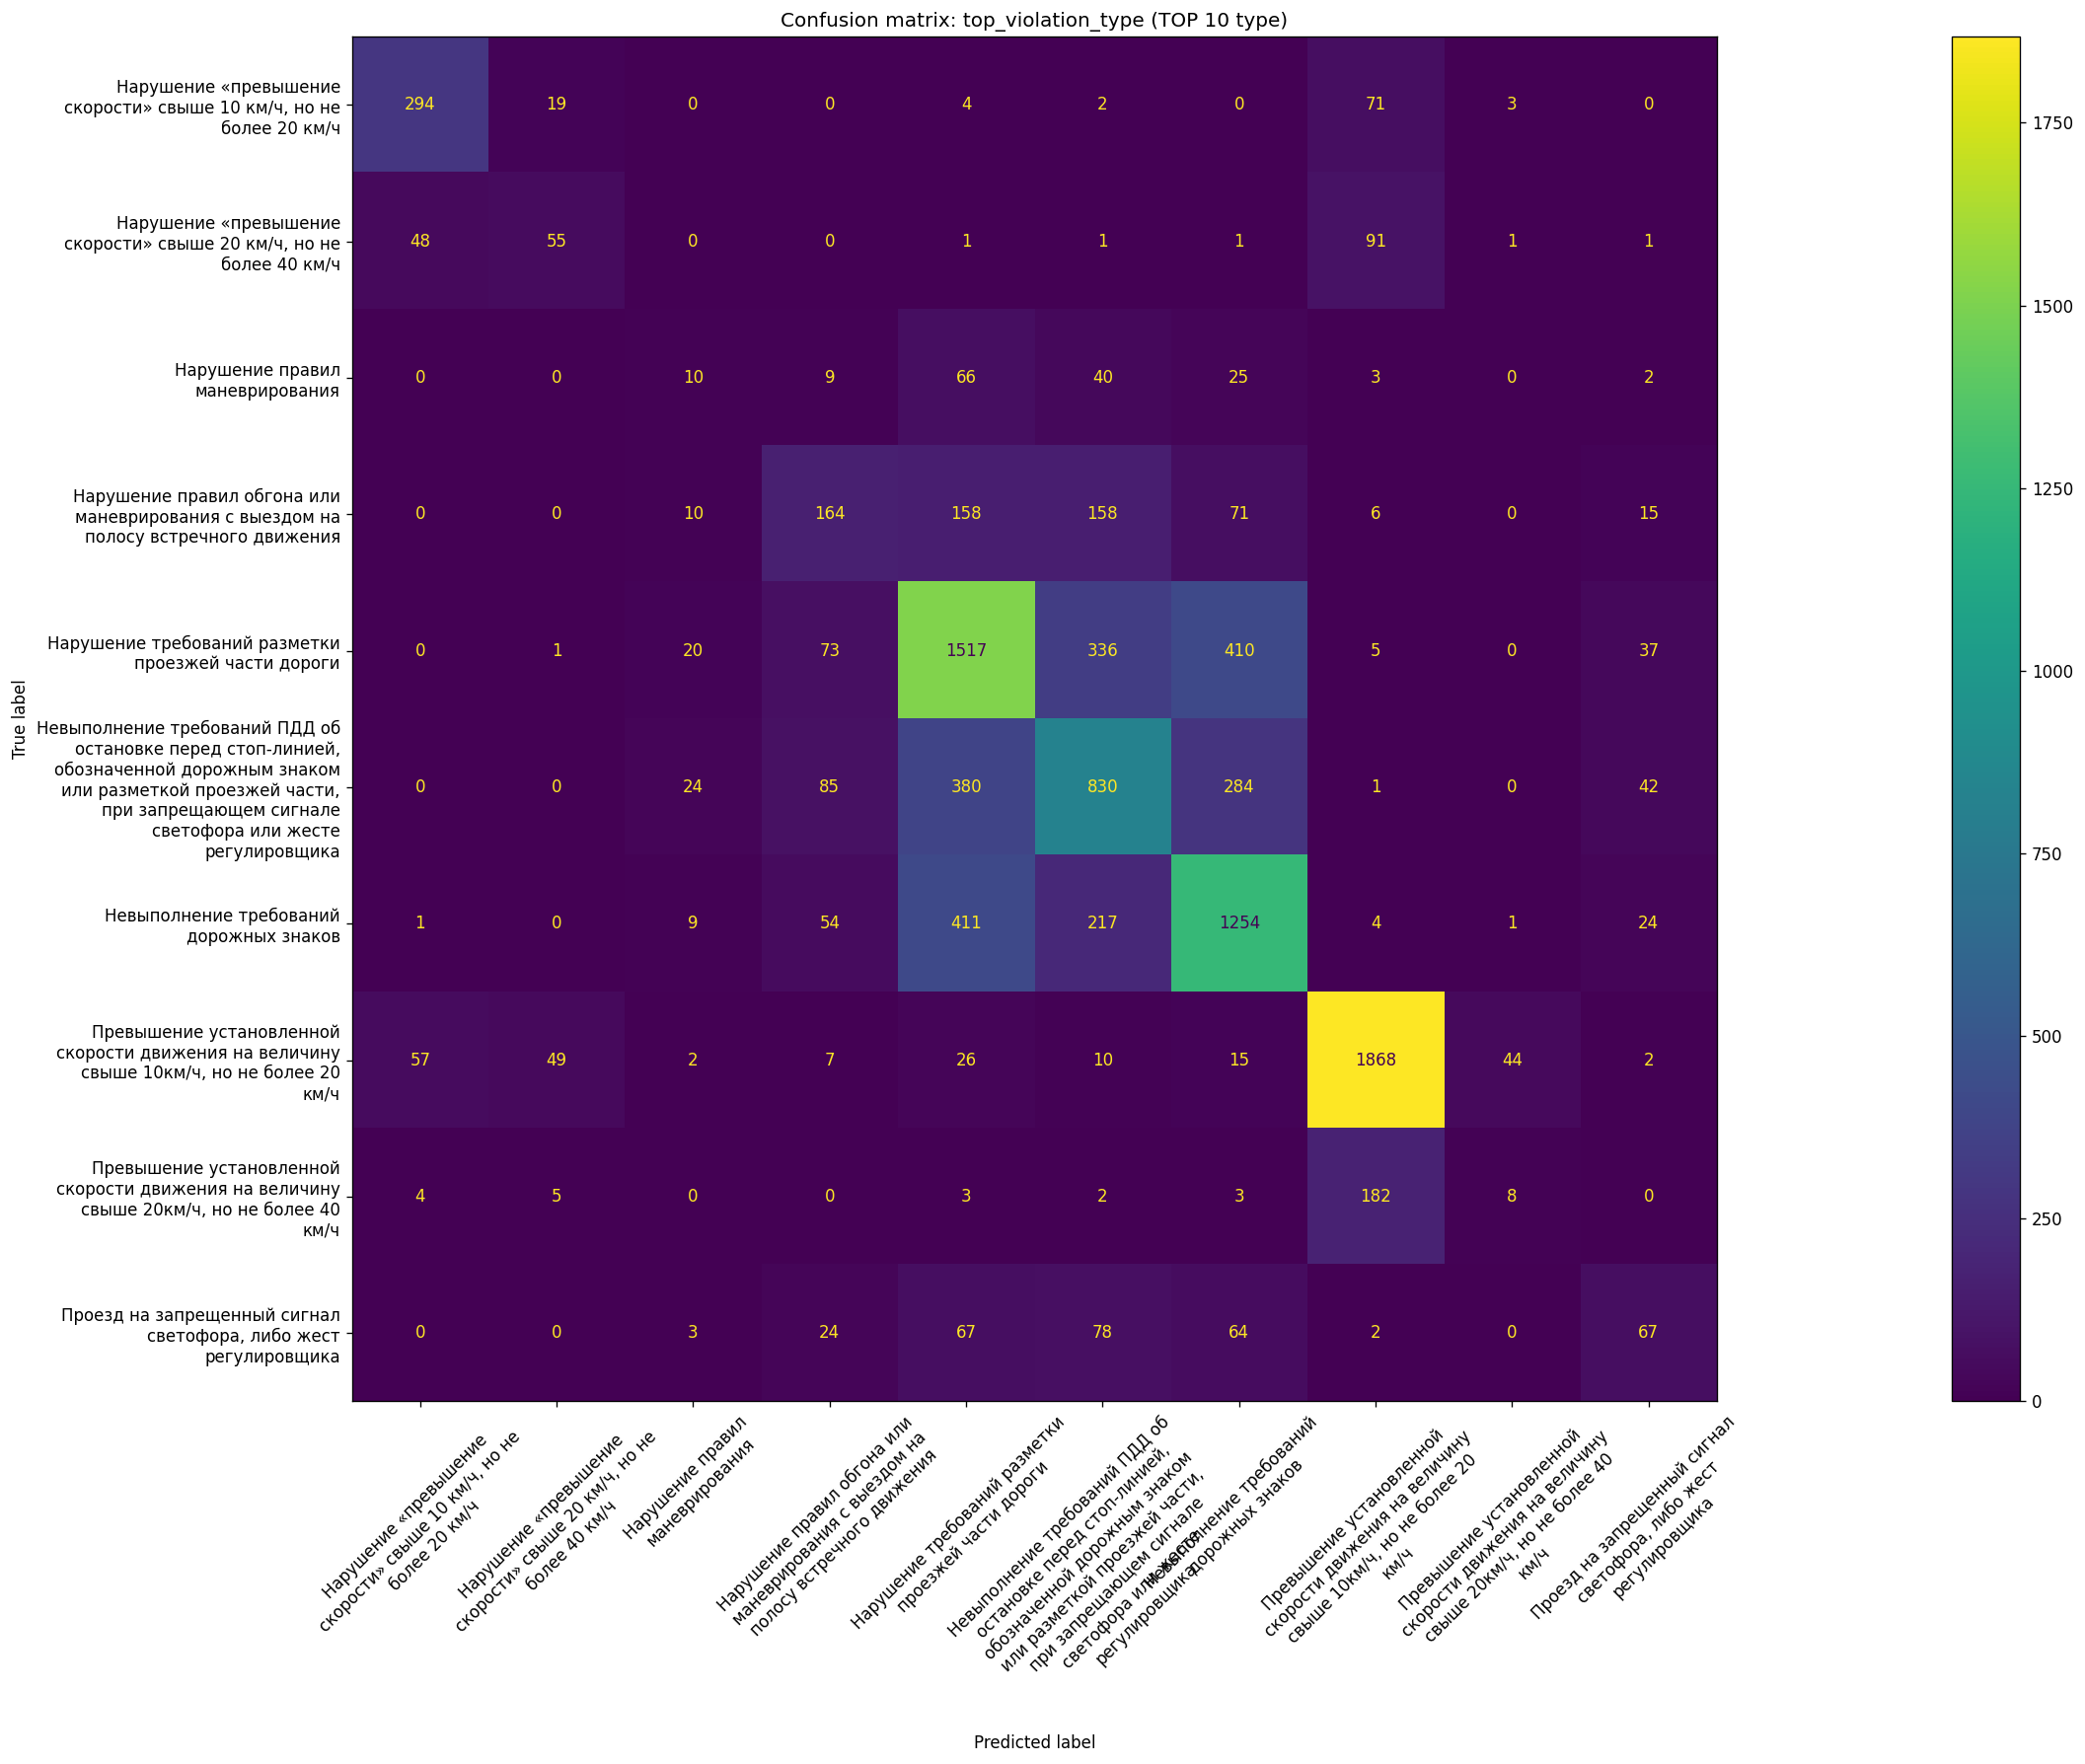

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import textwrap

labels = sorted(y_test_t.unique())

cm_t = confusion_matrix(y_test_t, y_pred_t, labels=labels)

wrapped_labels = [
    textwrap.fill(lbl, width=30)
    for lbl in labels
]

fig, ax = plt.subplots(figsize=(40, 15), dpi=120)

disp_t = ConfusionMatrixDisplay(
    confusion_matrix=cm_t,
    display_labels=wrapped_labels
)

disp_t.plot(
    ax=ax,
    xticks_rotation=45,
    values_format='d'
)

ax.set_title('Confusion matrix: top_violation_type (TOP 10 type)')
plt.tight_layout()
plt.show()
